<a href="https://colab.research.google.com/github/Arch-suzuki-MB/CNN-in-tensorflow/blob/main/Dog%20and%20cat%20classification%20with%20data%20aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "cats-and-dogs.zip"

--2022-12-14 09:52:52--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.54.200.233, 2600:1408:c400:1680::317f, 2600:1408:c400:168a::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.54.200.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘cats-and-dogs.zip’

cats-and-dogs.zip   100%[===================>] 786.67M   150MB/s    in 5.6s    

2022-12-14 09:52:58 (141 MB/s) - ‘cats-and-dogs.zip’ saved [824887076/824887076]



In [2]:
import tensorflow as tf 
import os
import shutil
import zipfile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
zip_ref=zipfile.ZipFile('cats-and-dogs.zip')
zip_ref.extractall('dataset')
zip_ref.close()
dataset=os.path.join('/content/dataset/PetImages')

In [4]:
folder_path=['/content/train',
             '/content/train/Cat',
             '/content/train/Dog',
             '/content/validation',
             '/content/validation/Cat',
             '/content/validation/Dog']

for path in folder_path :
  if os.path.exists(path)==False:
    os.mkdir(path)

path_train=os.path.join('/content/train')
path_val=os.path.join('/content/validation')

In [5]:
print('nbre de classe dans le dataset',os.listdir(dataset))
print('le nbre d\'images cats  ',len(os.listdir(dataset+'/Cat')))
print('le nbre d\'images dogs  ',len(os.listdir(dataset+'/Dog')))

nbre de classe dans le dataset ['Cat', 'Dog']
le nbre d'images cats   12501
le nbre d'images dogs   12501


In [6]:
def split_dataset(src_dir=dataset,target_dir=[path_train,path_val],split=0.9):
  class_names=os.listdir(dataset)
  class_names_train=os.listdir(path_train)
  class_names_val=os.listdir(path_val)

  for c in class_names:
    path_class=os.path.join(src_dir+'/'+c)
    img_names=[]
    for name in os.listdir(path_class):
      img_names.append(path_class+'/'+name)
  
    size_class=len(os.listdir(src_dir+'/'+c))
    size_train_split=int(size_class*split)
    #print(img_names)
    
    train_img=random.sample(img_names,size_train_split)
    val_img=list(set(img_names)-set(train_img))
    
    for i in train_img:
      target_class=os.path.join(target_dir[0]+'/'+c)
      if(os.path.getsize(i)):
        shutil.copy(i,target_class)
    
    for i in val_img:
      target_class=os.path.join(target_dir[1]+'/'+c)
      if(os.path.getsize(i)):
        shutil.copy(i,target_class)
  return  target_dir

In [7]:
target_dir=split_dataset()

## Data augmentation 

In [17]:
train_gen=ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    height_shift_range=0.3,
    width_shift_range=0.3,
    zoom_range=0.2,
    vertical_flip=True,
    shear_range=0.2,
    fill_mode='nearest')


train_generator=train_gen.flow_from_directory(
    target_dir[0],
    batch_size=45,
    class_mode='binary',
    target_size=(150,150))


val_gen=ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    height_shift_range=0.3,
    width_shift_range=0.3,
    zoom_range=0.2,
    vertical_flip=True,
    shear_range=0.2,
    fill_mode='nearest')

val_generator=val_gen.flow_from_directory(
    target_dir[1],
    batch_size=16,
    class_mode='binary',
    target_size=(150,150))

Found 22496 images belonging to 2 classes.
Found 2502 images belonging to 2 classes.


In [18]:
def design_model():
  model=tf.keras.models.Sequential([tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(150,150,3)),
                                    tf.keras.layers.MaxPooling2D((2,2)),
                                    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
                                    tf.keras.layers.MaxPooling2D((2,2)),
                                    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
                                    tf.keras.layers.MaxPooling2D((2,2)),

                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512,activation='relu'),
                                    tf.keras.layers.Dense(1,activation='sigmoid')
  ])
  model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
  return model

In [19]:
model=design_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 64)      

In [20]:
#train the model 
import warnings
warnings.filterwarnings('ignore')
hist = model.fit(
          train_generator,
          validation_data=val_generator,
          epochs=15
          )

Epoch 1/15
500/500 [==============================] - 723s 1s/step - loss: 0.6683 - acc: 0.5924 - val_loss: 0.6318 - val_acc: 0.6403
Epoch 2/15
500/500 [==============================] - 731s 1s/step - loss: 0.6215 - acc: 0.6518 - val_loss: 0.6044 - val_acc: 0.6910
Epoch 3/15
500/500 [==============================] - 726s 1s/step - loss: 0.5981 - acc: 0.6745 - val_loss: 0.5845 - val_acc: 0.6839
Epoch 4/15
500/500 [==============================] - 722s 1s/step - loss: 0.5784 - acc: 0.6905 - val_loss: 0.5783 - val_acc: 0.7186
Epoch 5/15
500/500 [==============================] - 726s 1s/step - loss: 0.5659 - acc: 0.7040 - val_loss: 0.5563 - val_acc: 0.7130
Epoch 6/15
500/500 [==============================] - 700s 1s/step - loss: 0.5506 - acc: 0.7163 - val_loss: 0.5265 - val_acc: 0.7398
Epoch 7/15
500/500 [==============================] - 666s 1s/step - loss: 0.5363 - acc: 0.7286 - val_loss: 0.5275 - val_acc: 0.7366
Epoch 8/15
500/500 [==============================] - 677s 1s/step - 

Text(0.5, 1.0, 'loss graph')

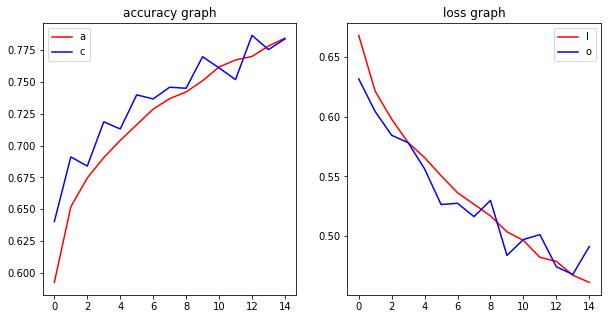

In [21]:
epochs=hist.epoch
acc=hist.history['acc']
val_acc=hist.history['val_acc']

loss=hist.history['loss']
val_loss=hist.history['val_loss']

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs,acc,'r')
plt.plot(epochs,val_acc,'b')
plt.title("accuracy graph")
plt.legend("accuracy")

plt.subplot(1,2,2)
plt.plot(epochs,loss,'r')
plt.plot(epochs,val_loss,'b')
plt.legend("loss")
plt.title("loss graph")